In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dists
import numpy as np

from interp_utils import reload_module


In [329]:

reload_module('interp_models')
from interp_models import Autoencoder, SparseAutoencoder, SparseNNMF
from tqdm import tqdm
from interp_utils import get_scheduler

reload_module('toy_models')
from toy_models import SparseIndependent, MonsterToy

N_FEATURES = 300
D_MODEL = 100
N_EPOCHS = 1
CODE_STEPS = 3000
ATOM_STEPS=1000
BATCH_SIZE=10000
SPARSE_COEF = 1

ORTHOG_K=False
ORTHOG_COEF = 1e-1 if ORTHOG_K is not False else 0.0


# toy = SparseIndependent(n_features=N_FEATURES, d_model=D_MODEL, feature_sparsity=0.04)
toy = MonsterToy(d_model=100, n_features=N_FEATURES, feature_prob=0.04, n_monster_features=6)


hidden_state, ground_truth = toy(D_MODEL)

nnmf = SparseNNMF(n_features=N_FEATURES, d_model=D_MODEL, orthog_k=ORTHOG_K, bias=True)


for epoch in range(N_EPOCHS):
    optimizer = optim.Adam(nnmf.parameters(), lr=1e-2)
    scheduler = get_scheduler(optimizer, CODE_STEPS)

    batch, true_codes = toy(BATCH_SIZE)


    # update codes
    nnmf.train(batch, frozen_atoms=epoch > 1, sparse_coef=SPARSE_COEF, n_steps=CODE_STEPS, reinit_codes=True, orthog_coef=ORTHOG_COEF, mean_init=False)

    # update atoms
    nnmf.train(batch, frozen_codes=True, sparse_coef=SPARSE_COEF, n_steps=ATOM_STEPS, orthog_coef=ORTHOG_COEF)



loss: 0.007, mse: 0.007: 100%|██████████| 1000/1000 [00:09<00:00, 100.44it/s]


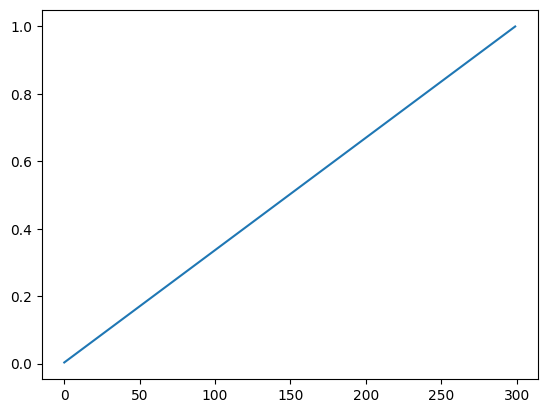

In [324]:
# # (1-(0.9)**np.arange(300))
# import matplotlib.pyplot as plt

# N_DIMS = 300

# plt.plot(np.arange(1, N_DIMS+1)/N_DIMS)

In [213]:
# normed_atoms = nnmf.normed_atoms
# codes = nnmf.codes.detach()

# orthog_k=5

# topk_vals, topk_idx = codes.topk(dim=-1, k=orthog_k)

# # topk_idx.shape


# active_atoms = torch.index_select(normed_atoms, dim=0, index=topk_idx.view(-1)).view(*topk_idx.shape, -1)
# mask = 1-torch.eye(orthog_k)
# see(active_atoms)

# active_atom_sims = torch.einsum('bkd,bld,kl->bkl', active_atoms, active_atoms, mask).abs().mean()*((orthog_k**2 - orthog_k)/orthog_k**2)

>> active_atoms: (10000, 5, 100)


In [222]:
active_atom_sims

tensor(0.0971, grad_fn=<MulBackward0>)

In [224]:
# from interp_utils import heatmap
# # (batch @ batch.T)
# batch_subset = batch[:100]

# heatmap(batch_subset @ batch_subset.T)


In [325]:
feature_idx = 2

codes = nnmf.codes.detach()
atoms = nnmf.atoms.detach()
toy_features = toy.features

atom_idx = (atoms @ toy_features.T)[:,feature_idx].argmax()
topk_codes = codes[:,atom_idx].topk(k=20).indices
true_codes[topk_codes][:,[0,1,feature_idx]]

tensor([[2.3043, 2.1748, 0.9713],
        [2.3465, 2.2256, 0.9667],
        [2.4399, 2.3043, 0.9911],
        [2.2942, 2.6700, 0.9771],
        [2.4334, 2.3640, 0.9634],
        [2.8889, 2.5797, 0.9900],
        [2.4606, 2.1528, 0.8379],
        [2.6027, 2.4632, 0.9841],
        [2.1894, 2.2592, 0.9096],
        [2.5156, 2.3296, 0.9415],
        [2.2191, 2.4388, 0.9672],
        [2.1753, 2.6041, 0.8663],
        [2.5333, 2.3668, 0.9498],
        [2.3351, 2.0977, 0.9093],
        [2.4408, 2.5167, 0.9891],
        [2.0814, 2.2048, 0.9514],
        [2.2480, 2.2552, 0.9916],
        [2.4327, 2.5292, 0.9805],
        [2.2977, 2.3635, 0.8166],
        [1.9621, 1.8085, 0.9391]])

In [543]:
# batch, features = toy(BATCH_SIZE)
# nnmf.train(batch, frozen_atoms=epoch > 1, sparse_coef=SPARSE_COEF, n_steps=CODE_STEPS, reinit_codes=True)

loss: 0.014, mse: 0.002, sparse: 0.012: 100%|██████████| 1000/1000 [00:24<00:00, 40.39it/s]


In [326]:
heatmap(nnmf.atoms @ nnmf.atoms.T)

In [327]:
from interp_utils import hist, heatmap

heatmap(nnmf.atoms @ toy.normed_features.T, dim_names=('learned atoms', 'true features'))

In [328]:
hist((nnmf.atoms @ toy.normed_features.T).abs().max(dim=0).values, info=range(N_FEATURES))

In [411]:
# from interp_utils import see, asee





tensor([[2.4700, 0.5899, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.6842, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.6518, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [2.5777, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.2689, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.5382, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [13]:
N_FEATURES = 10
FEATURE_PROB = 0.1
probs = torch.ones(N_FEATURES,)*FEATURE_PROB

dists.Bernoulli(probs).sample((10,))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])